# Imports

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_val_predict
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings 
warnings.filterwarnings('ignore')

# Read Data

In [5]:
#Считывание данных

train_data = pd.read_csv('dataset/train_data.csv', sep=';').dropna()
test_data = pd.read_csv('dataset/test_data.csv', sep=';').dropna()

train_data.columns = ['1','2', 'Bytes', 'Packages']
test_data.columns = ['1','2', 'Bytes', 'Packages']
print('train_shape: ',train_data.shape)
print('test_shape: ',test_data.shape)

train_shape:  (242405, 4)
test_shape:  (103910, 4)


In [6]:
train_data.head()

,1,2,Bytes,Packages
0,IoT,7708.0,221424.0,460.0
1,IoT,7714.0,221424.0,460.0
2,IoT,7717.0,108714.0,225.0
3,IoT,7729.0,216581.0,450.0
4,IoT,7735.0,217883.0,453.0


# Functions generate dataset

In [9]:
def getNewData(train_data):#Получение нового массива разделенного по времени на timeShift
    newData = {"Bytes": [],
          "Packages": []
              }

    timeShift = 3
    values = train_data.values
    for index in range(0, values.shape[0] - 1):
#         if index % 1000 == 0:
#             print(index, ' from ',  values.shape[0])
            
        value = values[index]
        nextValue = values[index + 1]
        #Сколько промежутков в этом интервале
        differentTime = (nextValue[1] - value[1]) / timeShift
        
        if differentTime < 1:
            newData["Bytes"].append(value[2])
            newData["Packages"].append(value[3])
            continue
        
        nextBytes = nextValue[2] / differentTime
        nextPackages = nextValue[3] / differentTime
        
        if nextPackages == 0:
            nextPackages = 1.0
            
        if math.isnan(value[1]) or math.isnan(nextValue[1]): 
            print("isNan")
            continue
        if int(value[1]) > int(nextValue[1]):
            print("func")
        
        for time in range(int(value[1]), int(nextValue[1]), timeShift):#Time
            newData["Bytes"].append(nextBytes)
            newData["Packages"].append(nextPackages)
            
    return newData

def generateDataset(data, ENTER_DATA_SIZE = 30):
    # Получение данных для тренировки; X and Y 
    # X - [[Bytes, Packages], [Bytes, Packages] ...] * lastData
    # Y - [Bytes, Packages]
    x_train = []
    y_train = []
    size = data.shape[0]
    for index in range(0, size - ENTER_DATA_SIZE, 1):
#         if index % 1000 == 0: 
#             print(index, ' from ', size)
        if index == 0:
            x_train = [data[index:index+ENTER_DATA_SIZE].values]
            y_train = data[index + ENTER_DATA_SIZE : index + ENTER_DATA_SIZE+ 1].values
            continue
#         print(x_train)
        x_train.append(data[index:index+ENTER_DATA_SIZE].values)
        y_train = np.append(y_train, data[index + ENTER_DATA_SIZE : index + ENTER_DATA_SIZE+ 1].values,axis=0 )
    return np.array(x_train), y_train

# Отрбрасываем выбросы данных 
def clearData(data):
    ind_missing = data[data['Bytes'] > 20000000].index
    data = data.drop(ind_missing, axis=0)
    
    ind_missing = data[data['Bytes'] < 20000].index
    data = data.drop(ind_missing, axis=0)
    data.boxplot(column=['Bytes'])
    return data

def plotNormalized(data):
    df_std = (data - data.mean()) / data.std()
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(data.keys(), rotation=90)
    
#Нормализовать данные
def normalizeData(data, train_mean, train_std): 
    return (data - train_mean) / train_std

#Вернуть данные в обратном
def unNormalizedData(data, train_mean, train_std):
    return (data * train_std) + train_mean

# Clean data from outliers

train data shape (332714, 2)
test data shape (279164, 2)


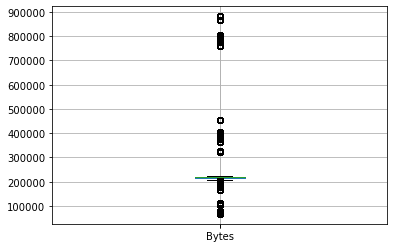

In [11]:
# Получение новых данных
clearedTimeShiftedTrainData = pd.DataFrame(getNewData(clearData(train_data)), columns = ['Bytes', 'Packages'])
clearedTestShiftedTestData = pd.DataFrame(getNewData(clearData(test_data)), columns = ['Bytes', 'Packages'])
print('train data shape', clearedTimeShiftedTrainData.shape)
print('test data shape', clearedTestShiftedTestData.shape)

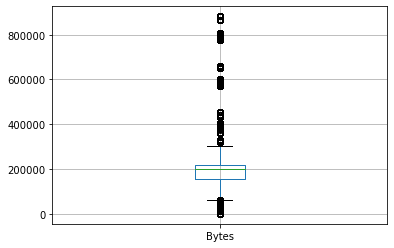

In [14]:
# Проверка разброса данных 
clearedTimeShiftedTrainData.boxplot(column=['Bytes'])

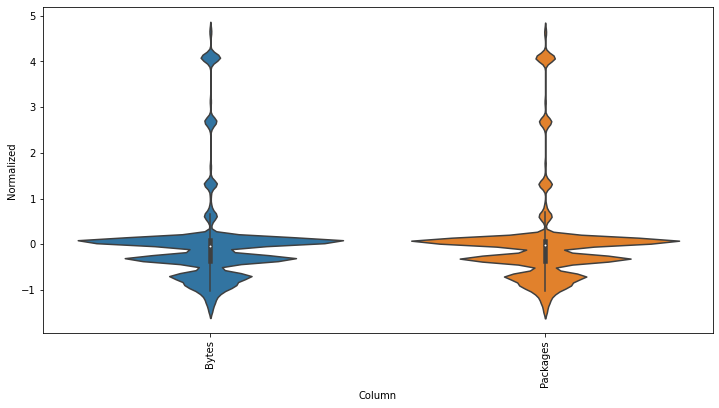

In [13]:
plotNormalized(clearedTimeShiftedTrainData)

# Generate Dataset with normalized values

In [15]:
n = len(clearedTimeShiftedTrainData)
train_df = clearedTimeShiftedTrainData[0:int(n*0.7)]
val_df = clearedTimeShiftedTrainData[int(n*0.7):]

clearedShiftedDataMean = train_df.mean()
clearedShiftedDataStd = train_df.std()


print(clearedShiftedDataMean,'\n',clearedShiftedDataStd)
train_df = normalizeData(train_df, clearedShiftedDataMean,clearedShiftedDataStd)
val_df = normalizeData(val_df, clearedShiftedDataMean, clearedShiftedDataStd)

ENTER_DATA_SIZE = 30
X_train, y_train = generateDataset(train_df, ENTER_DATA_SIZE=ENTER_DATA_SIZE)
X_val, y_val = generateDataset(val_df, ENTER_DATA_SIZE=ENTER_DATA_SIZE)
print(X_train.shape)
print(y_train.shape)

Bytes       208250.691197
Packages       435.958042
dtype: float64 
 Bytes       143913.912763
Packages       299.590957
dtype: float64
(232869, 30, 2)
(232869, 2)


# Train Model

In [16]:
def compile_and_fit(model, trainX, trainY, validData, patience=10, MAX_EPOCHS = 10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.075),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(trainX, trainY, epochs=MAX_EPOCHS,
                      validation_data=validData,
                      callbacks=[early_stopping])
    return history

In [17]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=2),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
#     tf.keras.layers.Reshape([1, -1]),
])


history = compile_and_fit(multi_step_dense, X_train, y_train, (X_val, y_val),MAX_EPOCHS= 50)

Epoch 1/50
7278/7278 [==============================] - 7s 918us/step - loss: 0.3499 - mean_absolute_percentage_error: 515.6801 - root_mean_squared_error: 0.5915 - val_loss: 0.3734 - val_mean_absolute_percentage_error: 1154.7860 - val_root_mean_squared_error: 0.6111
Epoch 2/50
7278/7278 [==============================] - 7s 897us/step - loss: 0.3072 - mean_absolute_percentage_error: 498.3002 - root_mean_squared_error: 0.5543 - val_loss: 0.2937 - val_mean_absolute_percentage_error: 548.8540 - val_root_mean_squared_error: 0.5419
Epoch 3/50
7278/7278 [==============================] - 6s 887us/step - loss: 0.2949 - mean_absolute_percentage_error: 487.3258 - root_mean_squared_error: 0.5430 - val_loss: 0.3446 - val_mean_absolute_percentage_error: 1059.4362 - val_root_mean_squared_error: 0.5870
Epoch 4/50
7278/7278 [==============================] - 7s 917us/step - loss: 0.2885 - mean_absolute_percentage_error: 478.8208 - root_mean_squared_error: 0.5371 - val_loss: 0.3495 - val_mean_absolute

# Predict for Validation dataset

In [18]:
predicted = multi_step_dense.predict(X_train)
evalute =  multi_step_dense.evaluate(X_val, y_val)
evalute

3119/3119 [==============================] - 2s 559us/step - loss: 0.2907 - mean_absolute_percentage_error: 284.6475 - root_mean_squared_error: 0.5392


[0.29073333740234375, 284.64752197265625, 0.5391969084739685]

# Functions for plot diagrams

In [19]:
def plotGraph(xTrain, trueVal, predicted):
    x1 = [x for x in range(0, 93, 3)]

    y1 = np.append(xTrain , trueVal)

    plt.subplot(1, 1, 1)
    plt.plot(x1, y1, 'o-')

    plt.plot(90, predicted, 'go') 
    plt.xlabel('time (s)')
    plt.ylabel('Undamped')

    plt.show()
    
    
def plotGraphWithDots(xTrain, trueVal, predicted):
    x1 = [x for x in range(0, len(xTrain) * 3 + 3, 3)]
    x2 = [x for x in range(0 , len(predicted) * 3, 3)]
    
    y1 = np.append(xTrain , trueVal)
    
    plt.subplot(1, 1, 1)
    plt.plot(x1, y1, 'o-')
    
    plt.plot(x2, predicted, 'go') 
    
    plt.xlabel('time (s)')
    plt.ylabel('Undamped')

    plt.show()

# Generate dataset for Test 
## And prediction for him

In [20]:
X_test1, y_test1 = generateDataset(clearedTestShiftedTestData, ENTER_DATA_SIZE=ENTER_DATA_SIZE)

In [21]:
#Тестовые данные
normalizedClearedTestShiftedData = normalizeData(clearedTestShiftedTestData, clearedShiftedDataMean,clearedShiftedDataStd)
X_test, y_test = generateDataset(normalizedClearedTestShiftedData, ENTER_DATA_SIZE=ENTER_DATA_SIZE)


In [24]:
multi_step_dense.evaluate(X_test, y_test)
predictTestNumpy = multi_step_dense.predict(X_test)
predictTest = pd.DataFrame(predictTestNumpy, columns = ['Bytes', 'Packages'])

8723/8723 [==============================] - 5s 540us/step - loss: 0.5598 - mean_absolute_percentage_error: 216.7857 - root_mean_squared_error: 0.7482


# Functions for calculate MAPE 

In [30]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print("MAPE BYTES = ", mean_absolute_percentage_error(y_test[:,0], predictTestNumpy[:,0]))
print("MAPE PACKAGES = ", mean_absolute_percentage_error(y_test[:,1], predictTestNumpy[:,1]))

MAPE BYTES =  152.0300255691253
MAPE PACKAGES =  281.54149950290406


# Unnormalized test data MAPE

In [33]:
predictedUnNormalized = unNormalizedData(predictTest,clearedShiftedDataMean,clearedShiftedDataStd)

y_test_UnNormalized = pd.DataFrame(y_test, columns = ['Bytes', 'Packages'])
y_test_UnNormalized = unNormalizedData(y_test_UnNormalized,clearedShiftedDataMean,clearedShiftedDataStd)

print("MAPE BYTES = ", mean_absolute_percentage_error(np.array(y_test_UnNormalized)[:,0], np.array(predictedUnNormalized)[:,0]))
print("MAPE PACKAGES = ", mean_absolute_percentage_error(np.array(y_test_UnNormalized)[:,1], np.array(predictedUnNormalized)[:,1]))

MAPE BYTES =  178.7845189412035
MAPE PACKAGES =  169.83437817239388


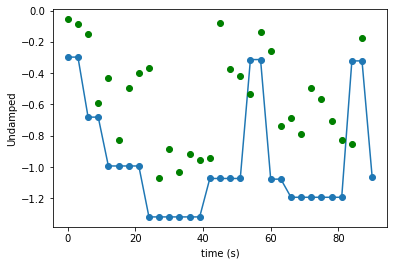

In [34]:
pointIndex=10002
plotGraphWithDots(X_test[pointIndex][:,0],y_test[pointIndex][0],
                  predicted=predictTest.values[pointIndex - ENTER_DATA_SIZE:pointIndex][:,0])

# Save To File

In [36]:
predictedUnNormalized.to_csv("output_test.csv", sep=';')

In [39]:
multi_step_dense.save("model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [40]:
multi_step_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7808      
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  130       
Total params: 16,194
Trainable params: 16,194
Non-trainable params: 0
_________________________________________________________________
